In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("sway_static_features.csv")
df.shape

(90, 137)

In [4]:
# Spalten, die NICHT aggregiert werden sollen
meta_cols = [
    "part_id", "group", "age_num", "sex", "height",
    "weight", "BMI", "recorded_in_the_lab", "faller"
]

# Alle numerischen Feature-Spalten
feature_cols = [c for c in df.columns if c not in meta_cols]

# Kennzahl-Präfixe
metrics = [
    "AREA", "MDIST", "MFREQ", "MVELO", "RDIST", "TOTEX"
]

# Ergebnis-DataFrame mit Metadaten
result = df[meta_cols].copy()

# Für jede Kennzahl den Mittelwert über alle Übungen berechnen
for metric in metrics:
    metric_cols = [c for c in feature_cols if c.startswith(metric)]
    result[f"{metric}_mean"] = df[metric_cols].mean(axis=1, skipna=True)

# Optional: AP- und ML-spezifische Mittelwerte
directions = ["AP", "ML"]

for metric in metrics:
    for d in directions:
        cols = [c for c in feature_cols if c.startswith(f"{metric}_{d}")]
        if cols:
            result[f"{metric}_{d}_mean"] = df[cols].mean(axis=1, skipna=True)

result.to_csv("sway_static_featuers_minimized.csv", index=False)

In [5]:
result = result.drop(columns=["part_id", "group"])

In [6]:
result.head()

,age_num,sex,height,weight,BMI,recorded_in_the_lab,faller,AREA_mean,MDIST_mean,MFREQ_mean,...,MDIST_AP_mean,MDIST_ML_mean,MFREQ_AP_mean,MFREQ_ML_mean,MVELO_AP_mean,MVELO_ML_mean,RDIST_AP_mean,RDIST_ML_mean,TOTEX_AP_mean,TOTEX_ML_mean
0,54,0,1.82,73.0,22.0,1,0,0.462000,0.191335,0.142527,...,0.178893,0.135229,0.105227,0.104870,0.235408,0.214811,0.210714,0.168083,2.336077,2.130114
1,71,0,1.80,81.6,25.2,1,1,5.350000,0.599354,0.177764,...,0.477494,0.532424,0.150722,0.169823,0.561982,0.705416,0.555086,0.637164,5.627817,7.044156
2,38,0,1.75,80.0,26.1,1,0,1.877500,0.391116,0.160584,...,0.437876,0.207755,0.139221,0.120324,0.496202,0.310260,0.515308,0.250151,4.957015,3.096353
3,56,0,1.75,70.0,22.9,1,0,2.321667,0.386111,0.165556,...,0.306667,0.341667,0.126667,0.150000,0.386667,0.501667,0.351667,0.445000,3.881667,5.008333
4,55,1,1.54,62.0,26.1,1,0,2.755000,0.402778,0.226111,...,0.385000,0.291667,0.160000,0.226667,0.568333,0.680000,0.461667,0.343333,5.686667,6.795000


Dataset shape: (90, 137)

Target distribution:
faller
0    66
1    24
Name: count, dtype: int64

Number of features: 133

Train set: 72 samples
Test set: 18 samples
Train class distribution:
faller
0    53
1    19
Name: count, dtype: int64

Starting GridSearchCV...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits

GRIDSEACHCV RESULTS

Best Parameters: {'rf__max_depth': 3, 'rf__max_features': 0.3, 'rf__min_samples_leaf': 7, 'rf__min_samples_split': 15, 'rf__n_estimators': 100}
Best CV ROC-AUC Score: 0.6752

Train ROC-AUC: 0.9795
CV ROC-AUC: 0.6752
Overfitting Gap: 0.3043
⚠️  Warning: Possible overfitting detected!

TEST SET EVALUATION

Test ROC-AUC: 0.8769
Test Accuracy: 0.7222
Test F1-Score: 0.5455

Classification Report:
              precision    recall  f1-score   support

  Non-Faller       0.83      0.77      0.80        13
      Faller       0.50      0.60      0.55         5

    accuracy                           0.72        18
   macro avg       0.67      0.68  

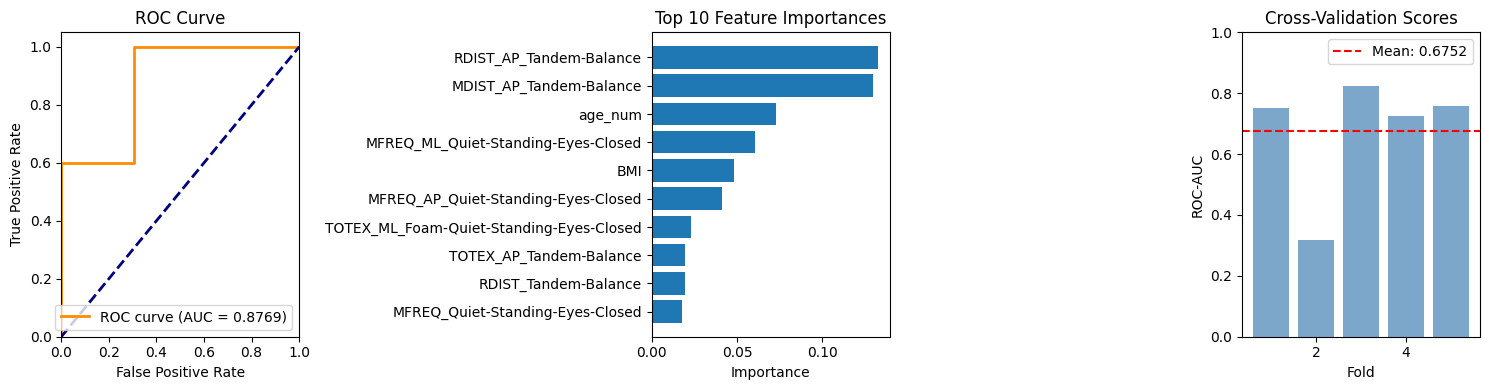


SUMMARY
Best Model: RandomForestClassifier
Best Parameters: {'rf__max_depth': 3, 'rf__max_features': 0.3, 'rf__min_samples_leaf': 7, 'rf__min_samples_split': 15, 'rf__n_estimators': 100}
CV ROC-AUC: 0.6752
Test ROC-AUC: 0.8769

Results saved to 'rf_classifier_results.png'


In [7]:
# =============================================================================
# Random Forest Classifier with GridSearchCV for Faller Prediction
# Optimized for ROC-AUC with Cross-Validation and Overfitting Prevention
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, accuracy_score, f1_score
)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv("sway_static_features.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:\n{df['faller'].value_counts()}")

# Define meta columns (non-features) - exclude from training
# Note: age_num, sex, height, weight, BMI ARE included as features
meta_cols = ["part_id", "group", "recorded_in_the_lab", "faller"]

# Feature columns (all numerical sway features)
feature_cols = [c for c in df.columns if c not in meta_cols]
print(f"\nNumber of features: {len(feature_cols)}")

# Prepare X and y
X = df[feature_cols]
y = df["faller"]

# Train-Test Split (Stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train class distribution:\n{y_train.value_counts()}")

# =============================================================================
# Pipeline with Imputation, Scaling, and Random Forest
# =============================================================================
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler()),  # Normalize features
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# =============================================================================
# GridSearchCV Parameter Grid
# Conservative parameters to prevent overfitting
# =============================================================================
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [3, 5, 7, 10, None],  # Limiting depth prevents overfitting
    'rf__min_samples_split': [5, 10, 15],  # Higher values prevent overfitting
    'rf__min_samples_leaf': [3, 5, 7],  # Higher values prevent overfitting
    'rf__max_features': ['sqrt', 'log2', 0.3],  # Limit features per tree
}

# =============================================================================
# Stratified K-Fold Cross Validation
# =============================================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =============================================================================
# GridSearchCV with ROC-AUC scoring
# =============================================================================
print("\n" + "="*60)
print("Starting GridSearchCV...")
print("="*60)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    return_train_score=True  # To detect overfitting
)

grid_search.fit(X_train, y_train)

# =============================================================================
# Results
# =============================================================================
print("\n" + "="*60)
print("GRIDSEACHCV RESULTS")
print("="*60)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV ROC-AUC Score: {grid_search.best_score_:.4f}")

# Check for overfitting (compare train vs CV scores)
best_idx = grid_search.best_index_
train_score = grid_search.cv_results_['mean_train_score'][best_idx]
cv_score = grid_search.cv_results_['mean_test_score'][best_idx]
print(f"\nTrain ROC-AUC: {train_score:.4f}")
print(f"CV ROC-AUC: {cv_score:.4f}")
print(f"Overfitting Gap: {train_score - cv_score:.4f}")

if train_score - cv_score > 0.15:
    print("⚠️  Warning: Possible overfitting detected!")
else:
    print("✓ Model appears well-generalized")

# =============================================================================
# Evaluate on Test Set
# =============================================================================
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

test_roc_auc = roc_auc_score(y_test, y_pred_proba)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"\nTest ROC-AUC: {test_roc_auc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Faller', 'Faller']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# =============================================================================
# Additional Cross-Validation on Full Training Data
# =============================================================================
print("\n" + "="*60)
print("CROSS-VALIDATION SCORES (Best Model on Train Set)")
print("="*60)

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# =============================================================================
# Feature Importance (Top 15)
# =============================================================================
print("\n" + "="*60)
print("TOP 15 FEATURE IMPORTANCES")
print("="*60)

rf_model = best_model.named_steps['rf']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

# =============================================================================
# Visualization
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# 2. Feature Importance (Top 10)
top_features = feature_importance.head(10)
axes[1].barh(range(len(top_features)), top_features['importance'].values)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['feature'].values)
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 10 Feature Importances')

# 3. CV Score Distribution
axes[2].bar(range(1, 6), cv_scores, color='steelblue', alpha=0.7)
axes[2].axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('ROC-AUC')
axes[2].set_title('Cross-Validation Scores')
axes[2].legend()
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('rf_classifier_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Best Model: RandomForestClassifier")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"CV ROC-AUC: {grid_search.best_score_:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")
print(f"\nResults saved to 'rf_classifier_results.png'")


Dataset shape: (90, 25)

Target distribution:
faller
0    66
1    24
Name: count, dtype: int64

Number of features: 21

Train set: 72 samples
Test set: 18 samples
Train class distribution:
faller
0    53
1    19
Name: count, dtype: int64

Starting GridSearchCV...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits

GRIDSEACHCV RESULTS

Best Parameters: {'rf__max_depth': 3, 'rf__max_features': 0.3, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}
Best CV ROC-AUC Score: 0.6198

Train ROC-AUC: 0.9925
CV ROC-AUC: 0.6198
Overfitting Gap: 0.3726
⚠️  Warning: Possible overfitting detected!

TEST SET EVALUATION

Test ROC-AUC: 0.8615
Test Accuracy: 0.7222
Test F1-Score: 0.4444

Classification Report:
              precision    recall  f1-score   support

  Non-Faller       0.79      0.85      0.81        13
      Faller       0.50      0.40      0.44         5

    accuracy                           0.72        18
   macro avg       0.64      0.62     

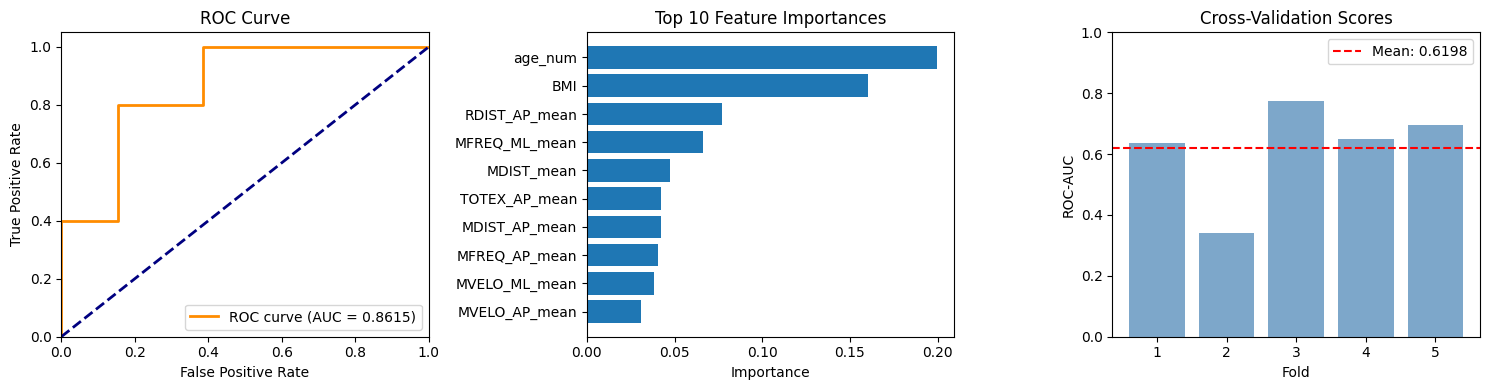


SUMMARY
Best Model: RandomForestClassifier
Best Parameters: {'rf__max_depth': 3, 'rf__max_features': 0.3, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}
CV ROC-AUC: 0.6198
Test ROC-AUC: 0.8615

Results saved to 'rf_classifier_results.png'


In [8]:
# =============================================================================
# Random Forest Classifier with GridSearchCV for Faller Prediction
# Optimized for ROC-AUC with Cross-Validation and Overfitting Prevention
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, accuracy_score, f1_score
)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv("sway_static_featuers_minimized.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:\n{df['faller'].value_counts()}")

# Define meta columns (non-features) - exclude from training
# Note: age_num, sex, height, weight, BMI ARE included as features
meta_cols = ["part_id", "group", "recorded_in_the_lab", "faller"]

# Feature columns (all numerical sway features)
feature_cols = [c for c in df.columns if c not in meta_cols]
print(f"\nNumber of features: {len(feature_cols)}")

# Prepare X and y
X = df[feature_cols]
y = df["faller"]

# Train-Test Split (Stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train class distribution:\n{y_train.value_counts()}")

# =============================================================================
# Pipeline with Imputation, Scaling, and Random Forest
# =============================================================================
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler()),  # Normalize features
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# =============================================================================
# GridSearchCV Parameter Grid
# Conservative parameters to prevent overfitting
# =============================================================================
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [3, 5, 7, 10, None],  # Limiting depth prevents overfitting
    'rf__min_samples_split': [5, 10, 15],  # Higher values prevent overfitting
    'rf__min_samples_leaf': [3, 5, 7],  # Higher values prevent overfitting
    'rf__max_features': ['sqrt', 'log2', 0.3],  # Limit features per tree
}

# =============================================================================
# Stratified K-Fold Cross Validation
# =============================================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =============================================================================
# GridSearchCV with ROC-AUC scoring
# =============================================================================
print("\n" + "="*60)
print("Starting GridSearchCV...")
print("="*60)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    return_train_score=True  # To detect overfitting
)

grid_search.fit(X_train, y_train)

# =============================================================================
# Results
# =============================================================================
print("\n" + "="*60)
print("GRIDSEACHCV RESULTS")
print("="*60)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV ROC-AUC Score: {grid_search.best_score_:.4f}")

# Check for overfitting (compare train vs CV scores)
best_idx = grid_search.best_index_
train_score = grid_search.cv_results_['mean_train_score'][best_idx]
cv_score = grid_search.cv_results_['mean_test_score'][best_idx]
print(f"\nTrain ROC-AUC: {train_score:.4f}")
print(f"CV ROC-AUC: {cv_score:.4f}")
print(f"Overfitting Gap: {train_score - cv_score:.4f}")

if train_score - cv_score > 0.15:
    print("⚠️  Warning: Possible overfitting detected!")
else:
    print("✓ Model appears well-generalized")

# =============================================================================
# Evaluate on Test Set
# =============================================================================
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

test_roc_auc = roc_auc_score(y_test, y_pred_proba)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"\nTest ROC-AUC: {test_roc_auc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Faller', 'Faller']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# =============================================================================
# Additional Cross-Validation on Full Training Data
# =============================================================================
print("\n" + "="*60)
print("CROSS-VALIDATION SCORES (Best Model on Train Set)")
print("="*60)

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# =============================================================================
# Feature Importance (Top 15)
# =============================================================================
print("\n" + "="*60)
print("TOP 15 FEATURE IMPORTANCES")
print("="*60)

rf_model = best_model.named_steps['rf']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

# =============================================================================
# Visualization
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# 2. Feature Importance (Top 10)
top_features = feature_importance.head(10)
axes[1].barh(range(len(top_features)), top_features['importance'].values)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['feature'].values)
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 10 Feature Importances')

# 3. CV Score Distribution
axes[2].bar(range(1, 6), cv_scores, color='steelblue', alpha=0.7)
axes[2].axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('ROC-AUC')
axes[2].set_title('Cross-Validation Scores')
axes[2].legend()
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('rf_classifier_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Best Model: RandomForestClassifier")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"CV ROC-AUC: {grid_search.best_score_:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")
print(f"\nResults saved to 'rf_classifier_results.png'")


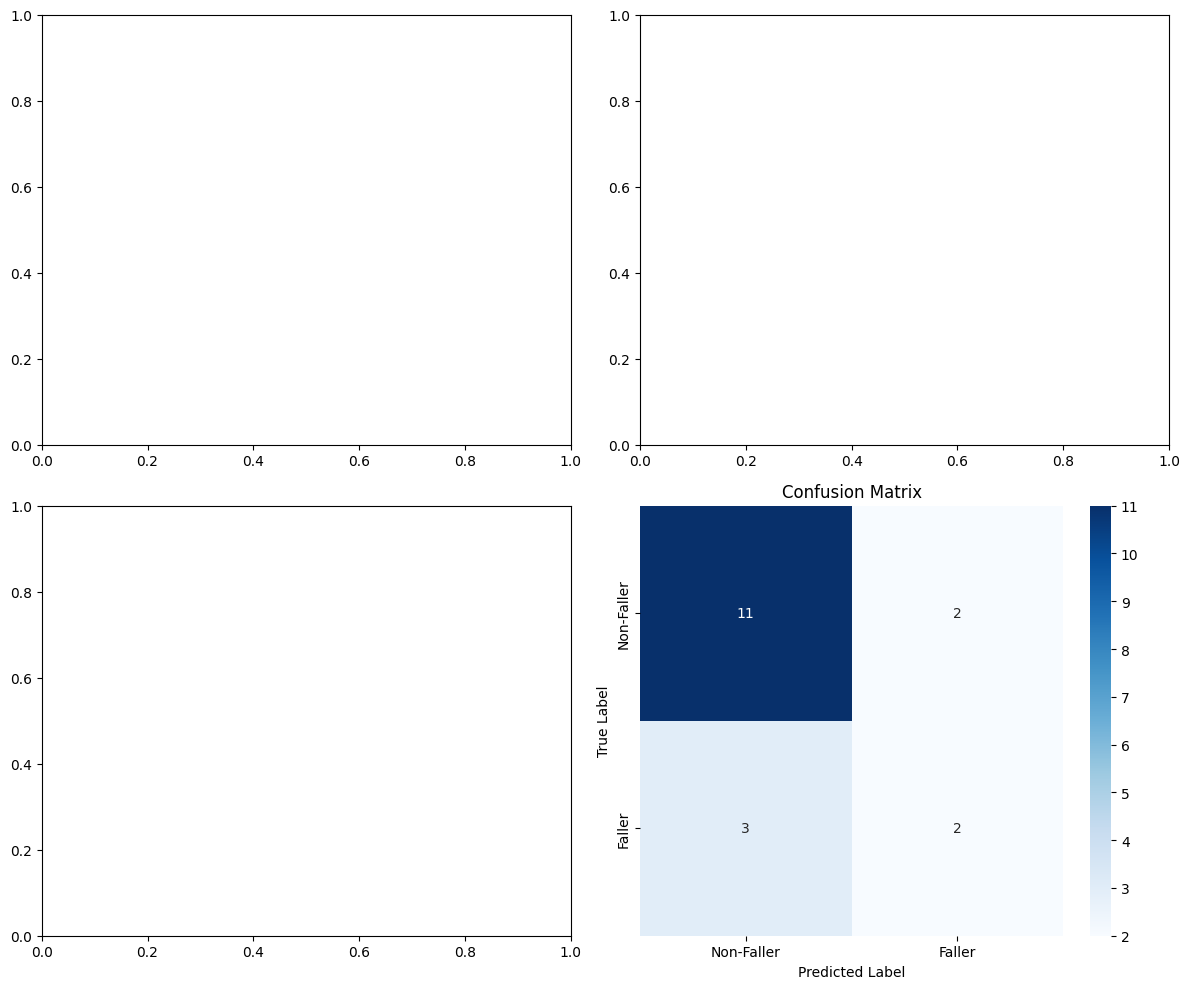

In [10]:
import seaborn as sns 
import matplotlib.pyplot as plt

# Initialize figure and axes first
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Non-Faller', 'Faller'],
            yticklabels=['Non-Faller', 'Faller'])
axes[1, 1].set_xlabel('Predicted Label')
axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_title('Confusion Matrix')

plt.tight_layout()
plt.savefig('rf_classifier_no_apml_results_fixed.png', dpi=150, bbox_inches='tight')
plt.show()
